In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib #
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D


# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, condition = None, number = None,
                           columns = None,
                           ranges = None, 
                           validation_frac = None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        if (validation_frac == None):
            warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
            validation_frac = 0.2
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = []
            df0 = self.get_data_of_a_track(filename = filename, columns = columns,ranges = ranges)
            df1.append(df0)
            
        df = pd.concat(df1, ignore_index=True)
        
        random_state = 1

        if (len(df['type'])*(1 - validation_frac) >= 10000):
            train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        else:
            train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
        
        #get rid of the pre-MS
        one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        one_track['type'] = 'vali'
        
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
            else:
                one_track = None
                break
        
        return one_track
    
    #############################################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    


# global_kernel 
# here we model the sun with GP -3D 

# set up path

In [3]:
datadr = '/Users/litz/Documents/GitHub/data/subset_feh_multiple/'
savedr = '/Users/litz/Documents/GitHub/GPflow/3D-teff-test3/'


In [4]:
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr)


Data path is set as/Users/litz/Documents/GitHub/data/subset_feh_multiple/
Save path is set as/Users/litz/Documents/GitHub/GPflow/3D-teff-test3/


# fundimential and observables

In [5]:
fundimential = ['star_mass', 'frac_age','star_age']
observable = ['effective_T' , 'log_g', 'initial_feh']
observable_value = [5777.0, 4.44, 0.0]
observable_error = [50.0, 0.05, 0.1]

# 1st we find out the ranges of input and outputs

In [6]:

columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [-0.5,0.5], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]

df = gmk.get_data_of_a_grid(condition = '*.csv', number = 20,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)
df

20 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,star_mass,frac_age,star_age,initial_feh,effective_T,log_g,type
0,1.01,0.006873,7.164600e+07,-0.5,5848.756261,4.537875,data
1,1.01,0.007632,7.955639e+07,-0.5,5852.256542,4.537216,vali
2,1.01,0.008543,8.904885e+07,-0.5,5855.697040,4.536556,data
3,1.01,0.009635,1.004398e+08,-0.5,5858.872771,4.535878,vali
4,1.01,0.010947,1.141090e+08,-0.5,5861.592299,4.535171,data
...,...,...,...,...,...,...,...
236,1.01,0.920779,9.598166e+09,-0.5,5659.353629,3.996434,vali
237,1.01,0.921746,9.608237e+09,-0.5,5651.379683,3.993528,data
238,1.01,0.922685,9.618034e+09,-0.5,5643.373641,3.990659,data
239,1.01,0.923600,9.627571e+09,-0.5,5635.310178,3.987819,data


In [7]:
#Here we obtained the parameter ranges, note that the frac_age range for all tracks need to be the same for a proper interpolation.  
np.min(df), np.max(df),len(df)


(star_mass            1.01
 frac_age       0.00687321
 star_age       7.1646e+07
 initial_feh          -0.5
 effective_T       5627.21
 log_g             3.98501
 type                 data
 dtype: object, star_mass             1.01
 frac_age          0.924491
 star_age       9.63685e+09
 initial_feh           -0.5
 effective_T        6035.06
 log_g              4.53788
 type                  vali
 dtype: object, 241)

# In test2 we failed to train 3D data derictly (teff = f(m, t, Z)) because the density in 3D space is not good enough. 
# So we change the procedure as follow: 
# 1. GP 2D surface teff = f(m,t) for each Z
# 2. Useing these 2D GP models to sample in 3D space
# 3. Train 3D GP.... (The downside of this method is that adding one dimension will add a new systematic uncersity, it hence hard to esitmate the total uncertainties. To solve this issus, an validation dataset is neccesary.)

In [8]:
# let us have a look at the data and train one surface before all.
columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [-0.5,0.5], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]

condition = '*feh0.0*.csv'
df = gmk.get_data_of_a_grid(condition = condition, number = None,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: $number$ is missing, all file will be used


40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


,star_mass,frac_age,star_age,initial_feh,effective_T,log_g,type
0,1.21,0.890725,4.980231e+09,0.0,5918.322075,3.911920,data
1,1.21,0.892043,4.987597e+09,0.0,5909.454757,3.909268,data
2,1.21,0.893306,4.994664e+09,0.0,5900.555948,3.906678,data
3,1.21,0.894520,5.001448e+09,0.0,5891.625958,3.904142,data
4,1.21,0.895686,5.007967e+09,0.0,5882.673821,3.901667,data
...,...,...,...,...,...,...,...
4063,1.13,0.915822,6.578331e+09,0.0,5666.085258,3.915227,data
4064,1.13,0.916558,6.583618e+09,0.0,5657.184672,3.913220,data
4065,1.13,0.917277,6.588780e+09,0.0,5648.258710,3.911243,vali
4066,1.13,0.917979,6.593825e+09,0.0,5639.324303,3.909296,data


# we plot Teff-logg-mass surface of the model grid.  

(0.85, 1.4)

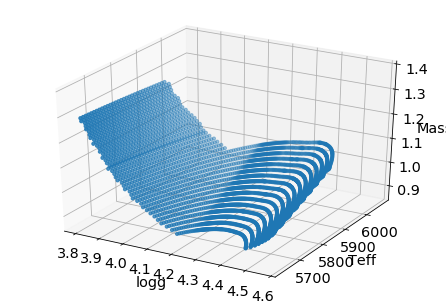

In [9]:
fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(df['log_g'], df['effective_T'], df['star_mass'], s=10)
ax.set_zlabel('Mass')
ax.set_xlabel('logg')
ax.set_ylabel('Teff')
ax.set_zlim([0.85,1.4])
#char = plt.colorbar(cp)
#char.set_label('[Fe/H]')

# And we train the surface with 2D GP

In [10]:
x1 = df['effective_T'][df['type'] == 'data'].to_numpy()
x2 = df['log_g'][df['type'] == 'data'].to_numpy()

z = df['star_mass'][df['type'] == 'data'].to_numpy().reshape(-1, 1)

x1_v = df['effective_T'][df['type'] == 'vali'].to_numpy()
x2_v = df['log_g'][df['type'] == 'vali'].to_numpy()

z_v = df['star_mass'][df['type'] == 'vali'].to_numpy().reshape(-1, 1)

x1.size

2848

In [12]:
# had to set this 
# to avoid the following error
# tensorflow.python.framework.errors_impl.InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]
gpflow.config.set_default_positive_minimum(1e-6)

# setup the kernel

k = gpflow.kernels.Matern12()


# set up GPR model

# I think the shape of the independent data
# should be (400, 2) for this case
xx = np.column_stack([[x1, x2]]).T
xx_v = np.column_stack([[x1_v, x2_v]]).T

print(xx.shape, xx_v.shape) # this will be (400, 2)

(2848, 2) (1220, 2)


In [13]:
m_teff = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

# optimise hyper-parameters
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m_teff.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m_teff.trainable_variables,
                        options=dict(maxiter=100)
                       )

In [14]:
mean, var = m_teff.predict_f(xx)

mean_v, var_v = m_teff.predict_f(xx_v)

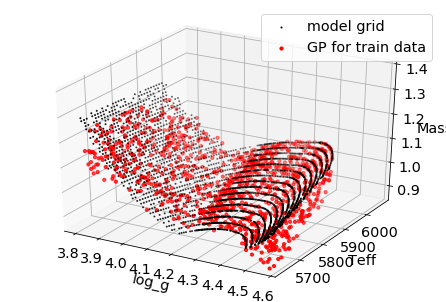

In [21]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x2, x1, z, s=1, c='k', label = 'model grid')
ax.scatter(x2_v, x1_v, mean_v, s=10, c= 'r', label = 'GP for train data')
ax.set_zlabel('Mass')
ax.set_xlabel('log_g')
ax.set_ylabel('Teff')
ax.set_zlim([0.85,1.4])
ax.legend()

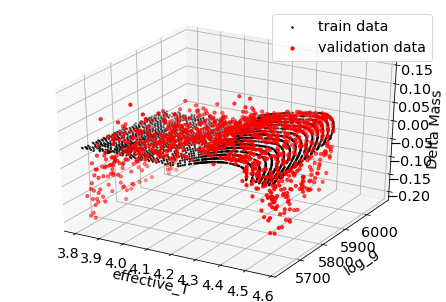

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x2, x1, mean - z, s=2, c='k', label = 'train data')
ax.scatter(x2_v, x1_v, mean_v - z_v, s=10, c='r', label = 'validation data')
ax.set_xlabel('effective_T')
ax.set_ylabel('log_g')
ax.set_zlabel('Delta Mass')
#ax.set_zlim([-30,50])
ax.legend()